In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

# import local packages
from utils import data_utils, training_utils
from utils.training_utils import train_model, test_model
from models.dense_convtranspose1d import DenseConvTranspose1D

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
pi = np.pi

# ================= Unit Define
meters = 1
centimeters = 1e-2 * meters
millimeters = 1e-3 * meters
micrometres = 1e-6 * meters

# ================= Constant Define
c0 = 3e8
e0 = 8.85e-12
u0 = 1.256e-6
yeta0 = np.sqrt(u0/e0)

# Looping to generate data and training

In [4]:
def visualize_trained_net(dataloader_test, size_fig=(21,12)):
    for idx, data in enumerate(dataloader_test):
        if idx>=4:
            break
        X, y = data
        X = X.to(device)
        y = y.to(device)
        y_pred = net_dense(X)  # [N_eg,2,N_freq]

        y_np = y.cpu().detach().numpy()
        y_pred_np = y_pred.cpu().detach().numpy()
        if idx==0:
            y_test_np = y_np
            y_test_pred_np = y_pred_np
        else:
            y_test_np = np.concatenate((y_test_np,y_np), axis=0)
            y_test_pred_np = np.concatenate((y_test_pred_np,y_pred_np), axis=0)
            
        if y_test_pred_np.shape[0]>=4:
            break
    print('y_test_np.shape:', y_test_np.shape)
    print('y_test_pred_np.shape:', y_test_pred_np.shape)

    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Training result on test set: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,0,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,0,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Training result on test set: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,1,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))
    plt.show()
    
    
def visualize_spectra_search(param_pick, R_pick, T_pick, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra search result: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra search result: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()
    
    
def visualize_learned_and_rcwa(param_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra of learned network and RCWA: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(R_simu.shape[1]), R_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra of learned network and RCWA: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(T_simu.shape[1]), T_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()

**************************** ROUND 1 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 15
Sample points number available, continue calculating...
----------------
[ 1 / 15 ] [D1, D2] = [149. 117.]
Calculation Progress: 100%
----------------
[ 2 / 15 ] [D1, D2] = [133. 114.]
Calculation Progress: 100%
----------------
[ 3 / 15 ] [D1, D2] = [ 55. 101.]
Calculation Progress: 100%
----------------
[ 4 / 15 ] [D1, D2] = [95. 99.]
Calculation Progress: 100%
----------------
[ 5 / 15 ] [D1, D2] = [ 91. 147.]
Calculation Progress: 100%
----------------
[ 6 / 15 ] [D1, D2] = [83. 91.]
Calculation Progress: 100%
----------------
[ 7 / 15 ] [D1, D2] = [ 78. 149.]
Calculation Progress: 100%
----------------
[ 8 / 15 ] [D1, D2] = [96. 78.]
Calculation Progress: 100%
----------------
[ 9 / 15 ] [D1, D2] = [71. 75.]
Calculation Progress: 100%
----------------
[ 10 / 15 ] [D1, D2] = [137.  54.]
Calculation Progress: 100%
----------------
[

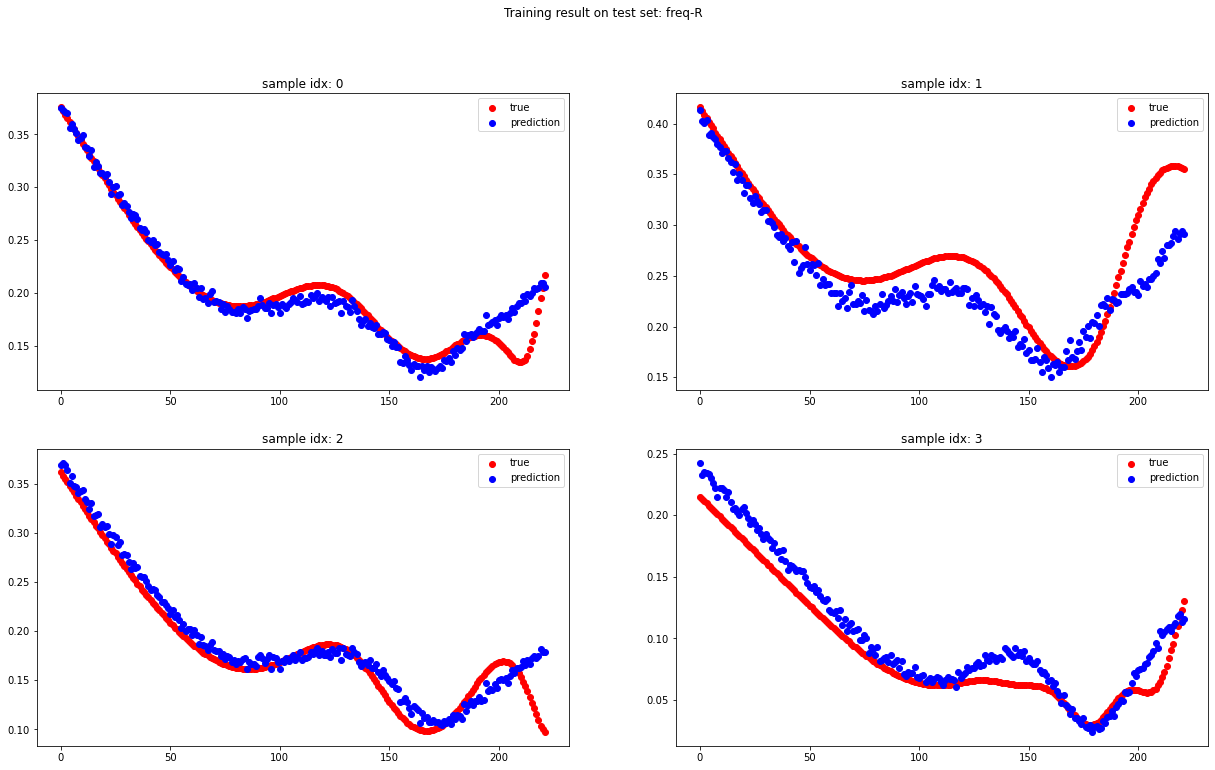

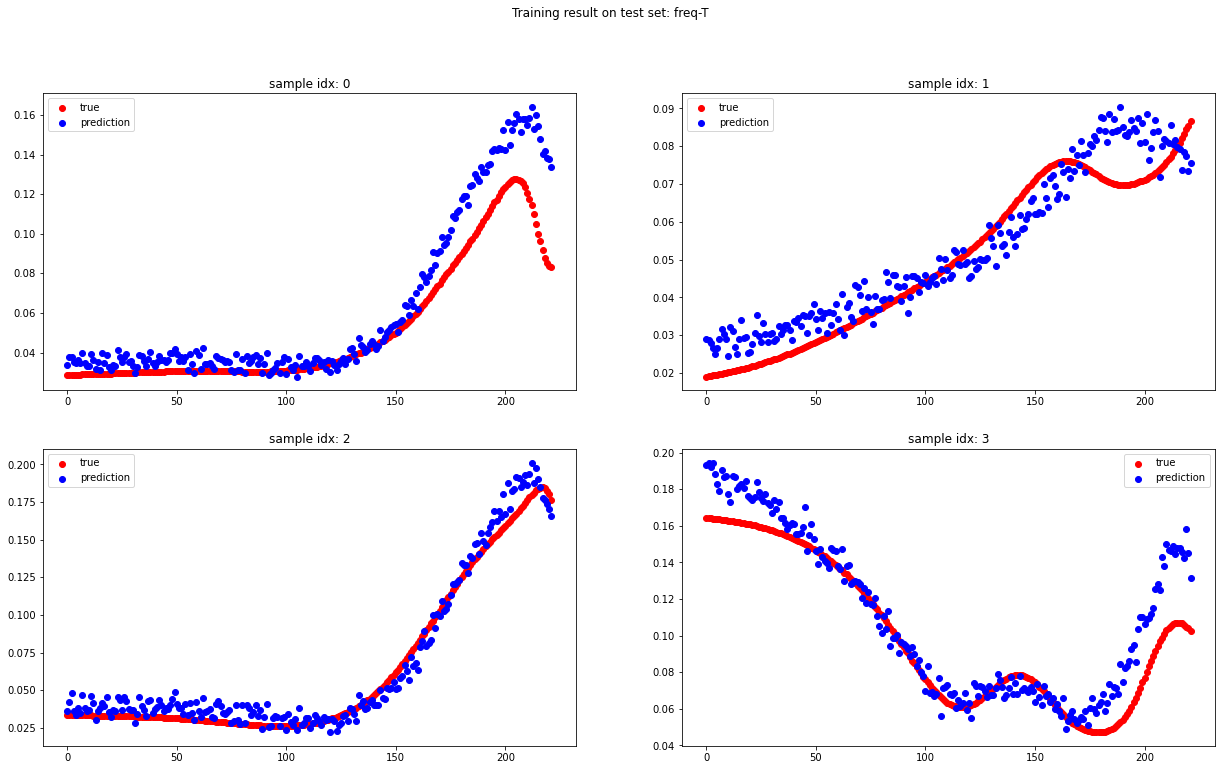

param_pick.shape: (10, 4)
param_pick: [[ 50. 149. 160.  75.]
 [ 51. 149. 160.  75.]
 [ 50. 148. 160.  75.]
 [ 50.  98. 160.  75.]
 [ 50.  99. 160.  75.]
 [ 50.  97. 160.  75.]
 [ 52. 149. 160.  75.]
 [ 50.  96. 160.  75.]
 [ 51. 148. 160.  75.]
 [ 50. 147. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


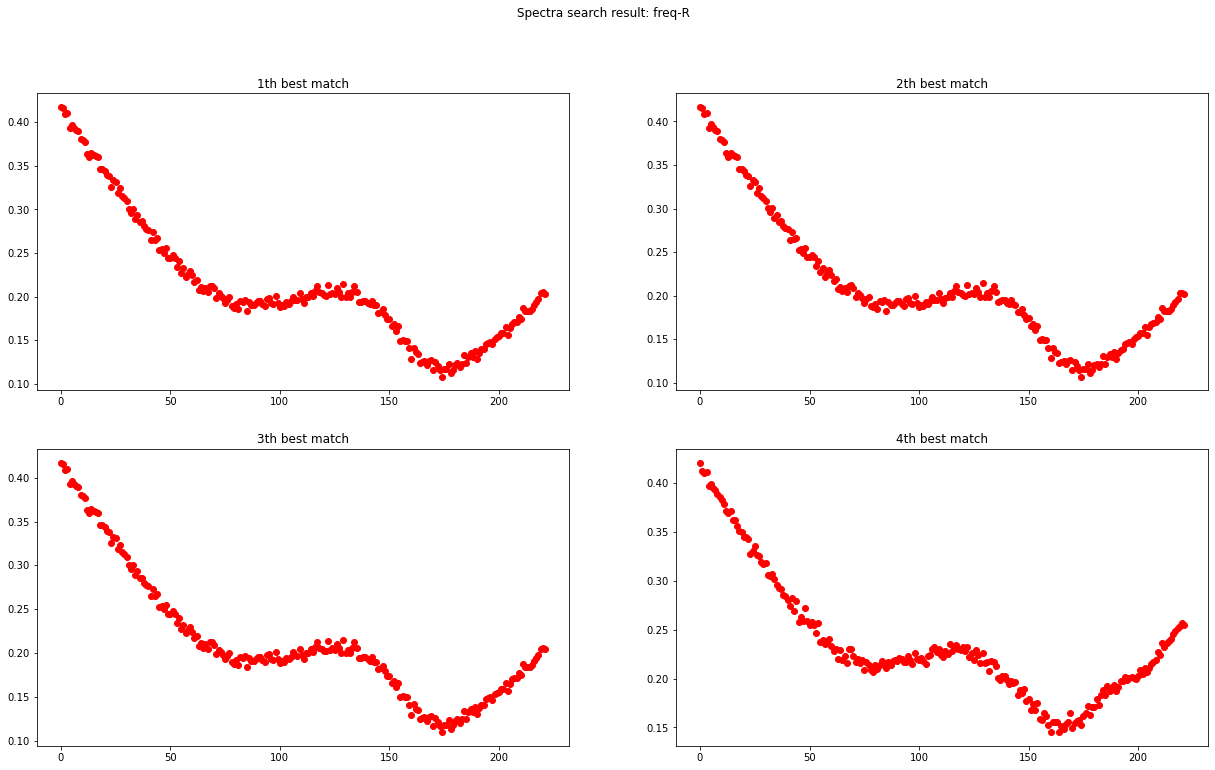

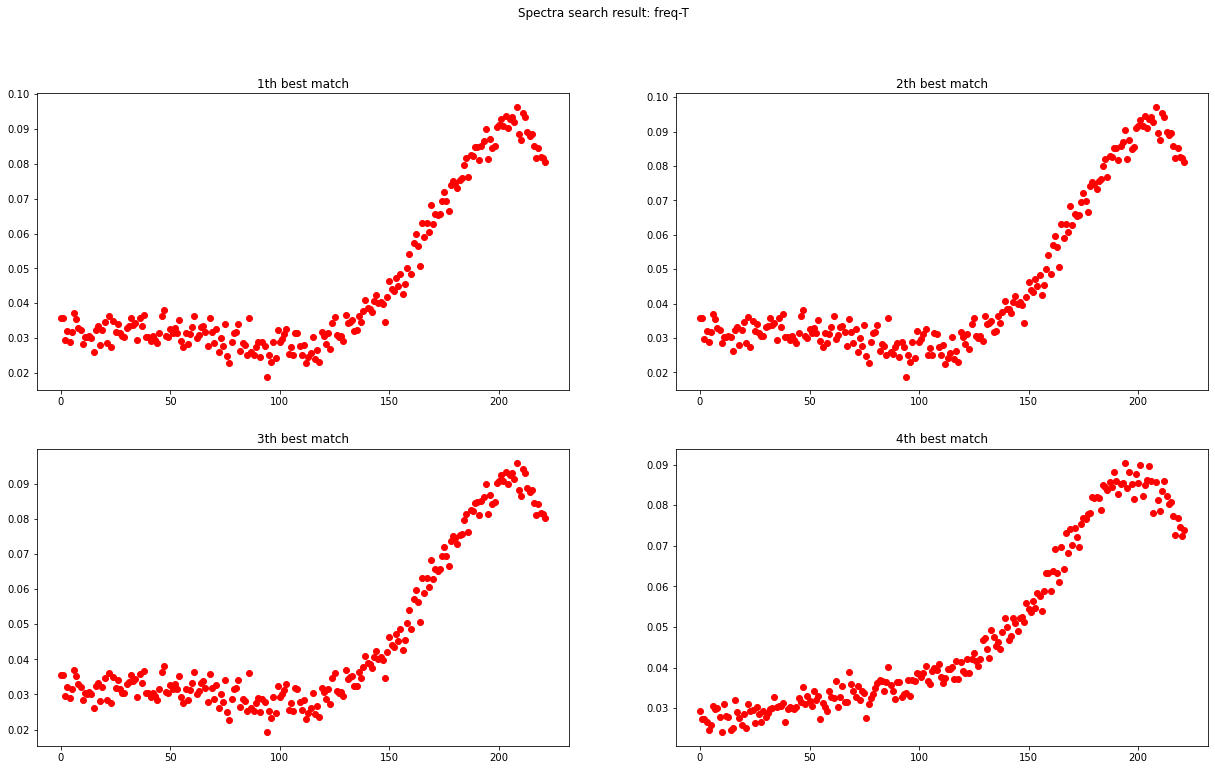

*** Reruning RCWA on picked params
Freq truncate.
freq.shape: (222,)
[ 1 / 10 ]
Calculation Progress: 100%
[ 2 / 10 ]
Calculation Progress: 100%
[ 3 / 10 ]
Calculation Progress: 100%
[ 4 / 10 ]
Calculation Progress: 100%
[ 5 / 10 ]
Calculation Progress: 100%
[ 6 / 10 ]
Calculation Progress: 100%
[ 7 / 10 ]
Calculation Progress: 100%
[ 8 / 10 ]
Calculation Progress: 100%
[ 9 / 10 ]
Calculation Progress: 100%
[ 10 / 10 ]
Calculation Progress: 100%
rerun_params.shape: (10, 4)
R_simu.shape: (10, 222)
T_simu.shape: (10, 222)
*** Average Loss between Trained Spectra and RCWA Spectra: 0.40324041443805736


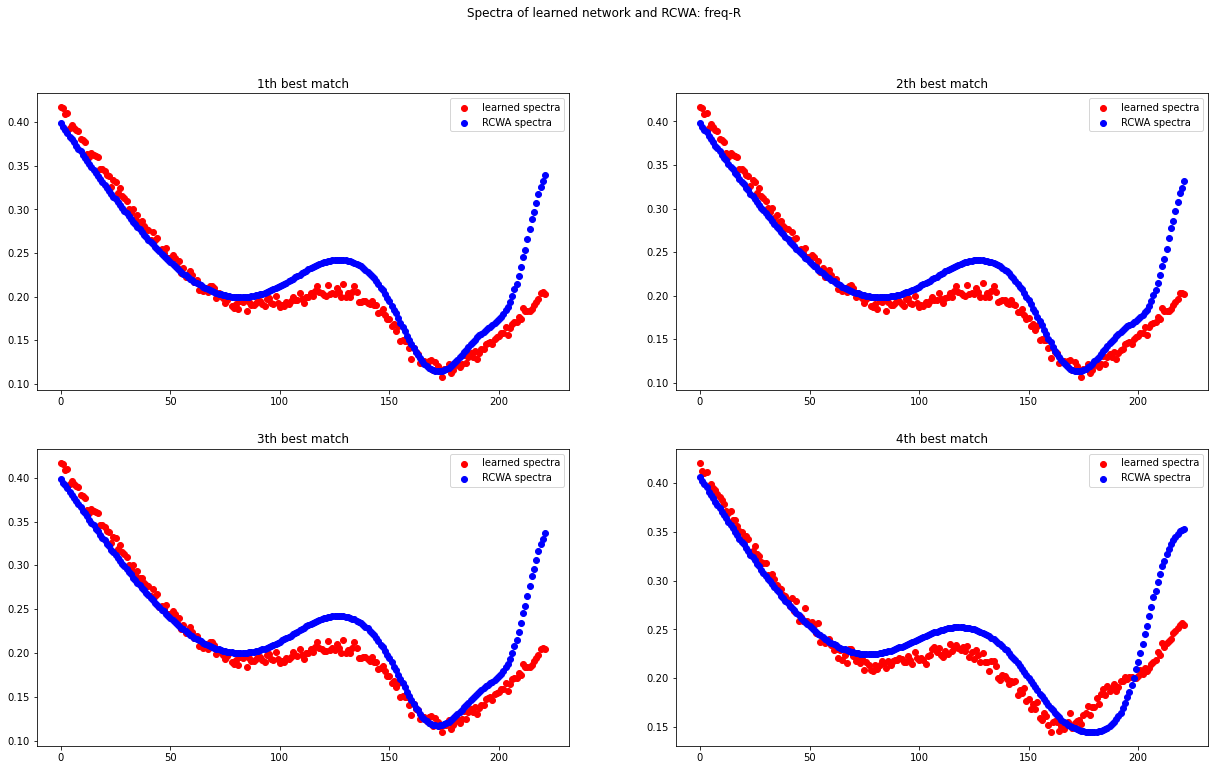

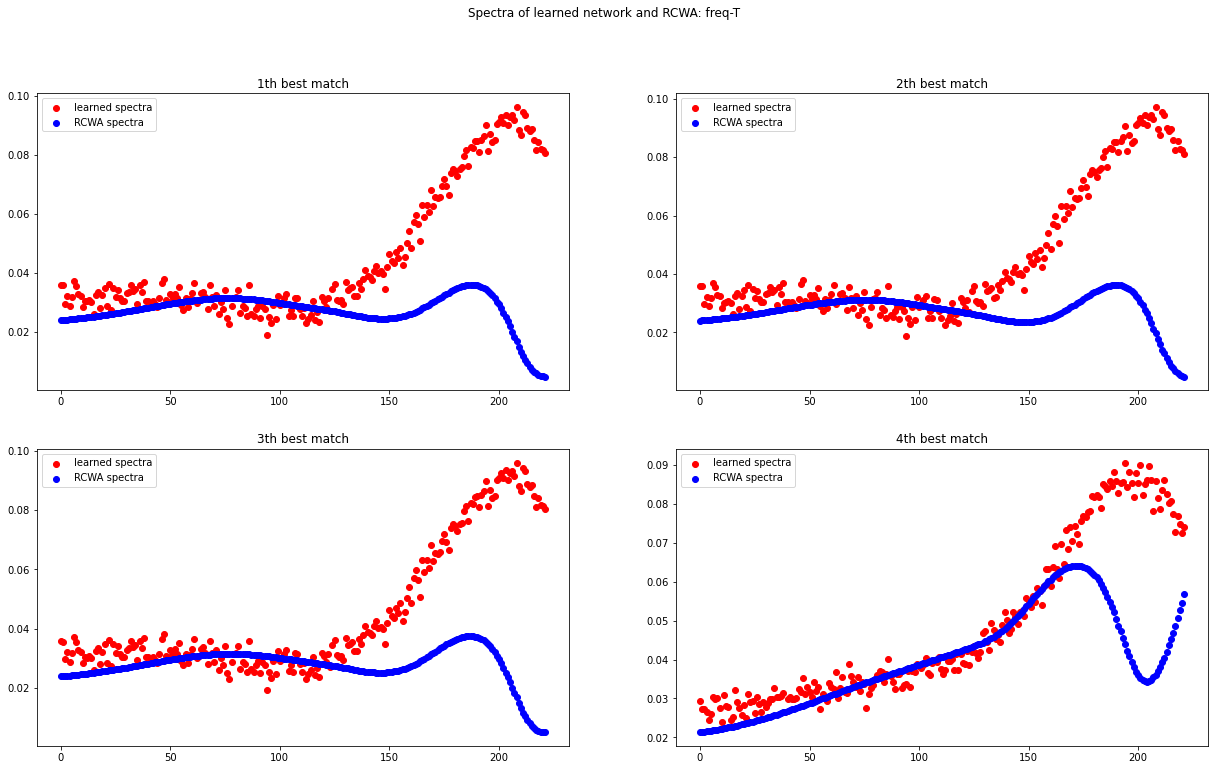

Model saved.
**************************** ROUND 2 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 30
Sample points number available, continue calculating...
----------------
[ 1 / 15 ] [D1, D2] = [132.  77.]
Calculation Progress: 100%
----------------
[ 2 / 15 ] [D1, D2] = [128.  86.]
Calculation Progress: 100%
----------------
[ 3 / 15 ] [D1, D2] = [127.  93.]
Calculation Progress: 100%
----------------
[ 4 / 15 ] [D1, D2] = [77. 85.]
Calculation Progress: 100%
----------------
[ 5 / 15 ] [D1, D2] = [95. 79.]
Calculation Progress: 100%
----------------
[ 6 / 15 ] [D1, D2] = [143. 100.]
Calculation Progress: 100%
----------------
[ 7 / 15 ] [D1, D2] = [133.  66.]
Calculation Progress: 100%
----------------
[ 8 / 15 ] [D1, D2] = [ 74. 101.]
Calculation Progress: 100%
----------------
[ 9 / 15 ] [D1, D2] = [ 56. 119.]
Calculation Progress: 100%
----------------
[ 10 / 15 ] [D1, D2] = [114. 101.]
Calculation Progress: 100%
-

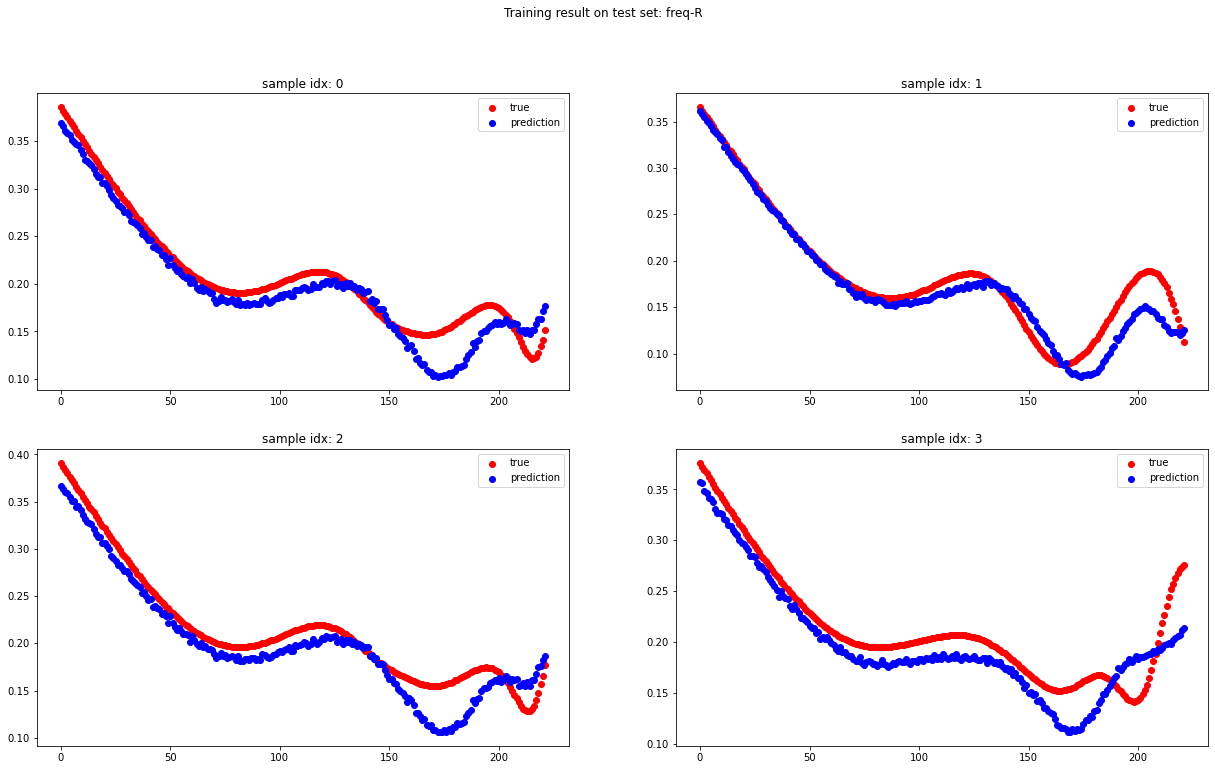

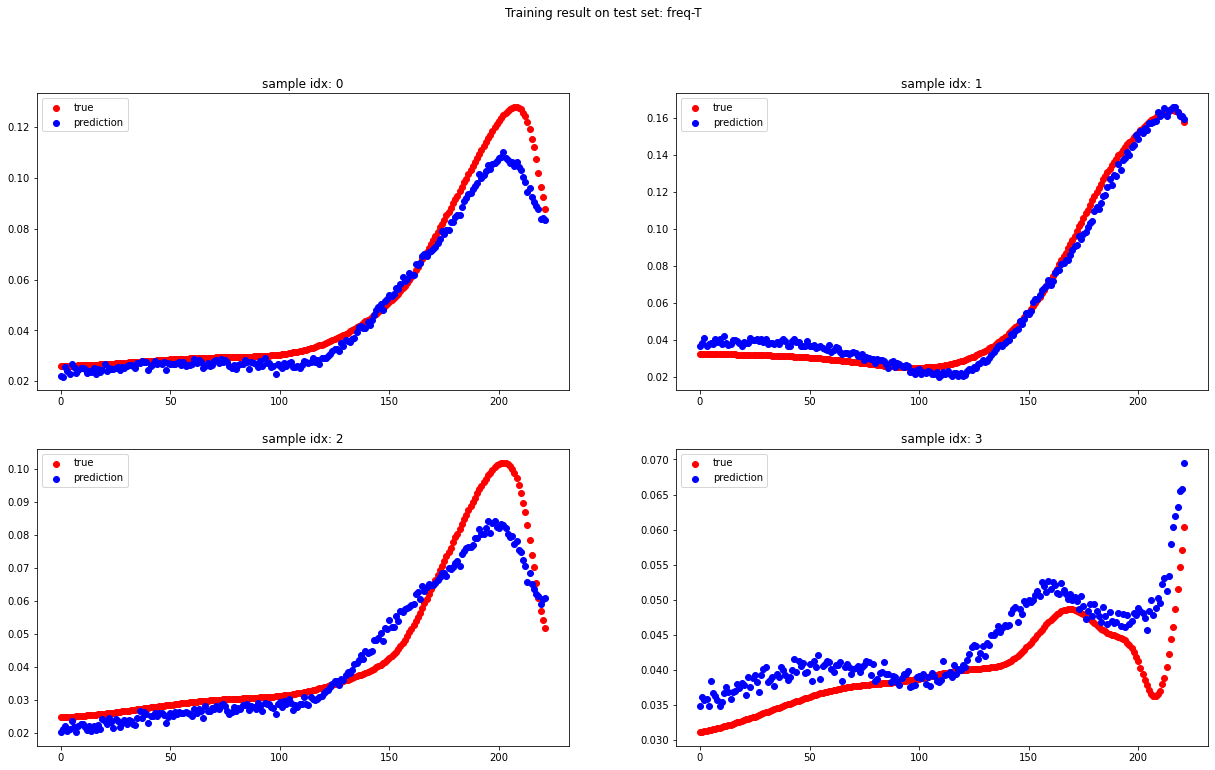

param_pick.shape: (10, 4)
param_pick: [[ 50.  50. 160.  75.]
 [ 51.  50. 160.  75.]
 [ 50.  51. 160.  75.]
 [ 52.  50. 160.  75.]
 [ 51.  51. 160.  75.]
 [ 50.  52. 160.  75.]
 [ 53.  50. 160.  75.]
 [ 52.  51. 160.  75.]
 [ 51.  52. 160.  75.]
 [ 50.  53. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


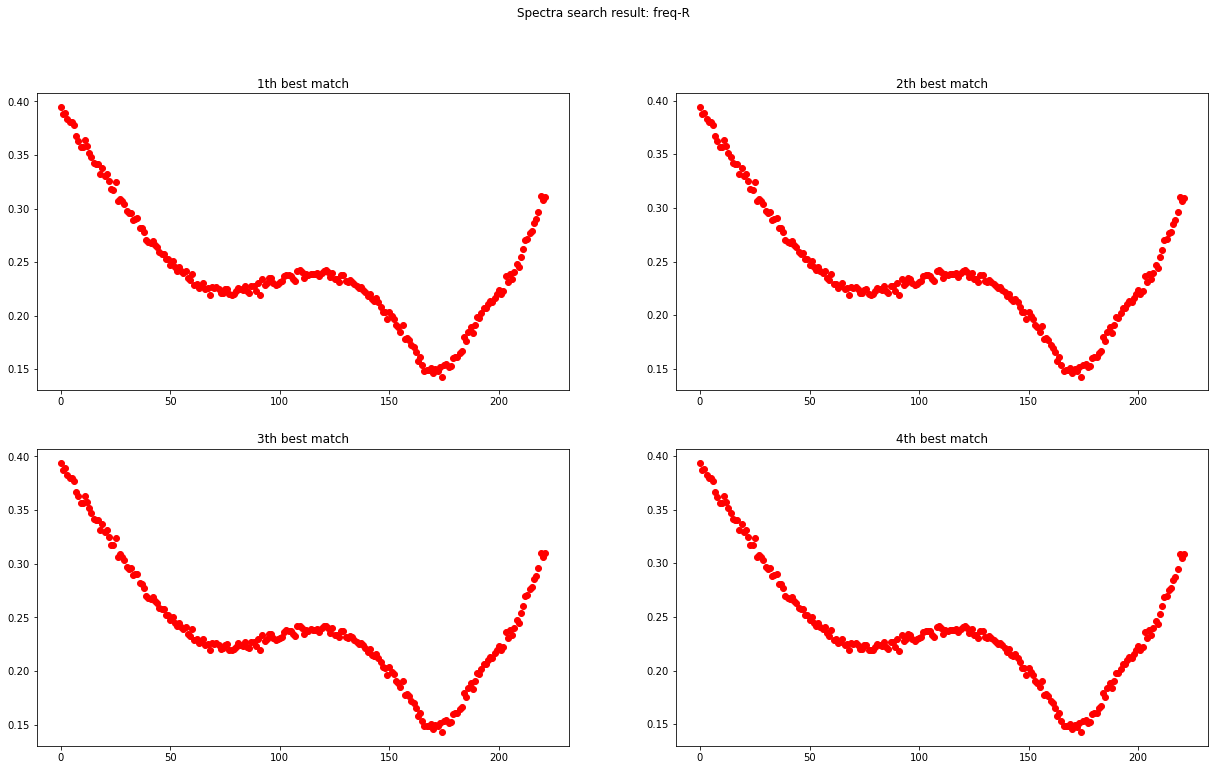

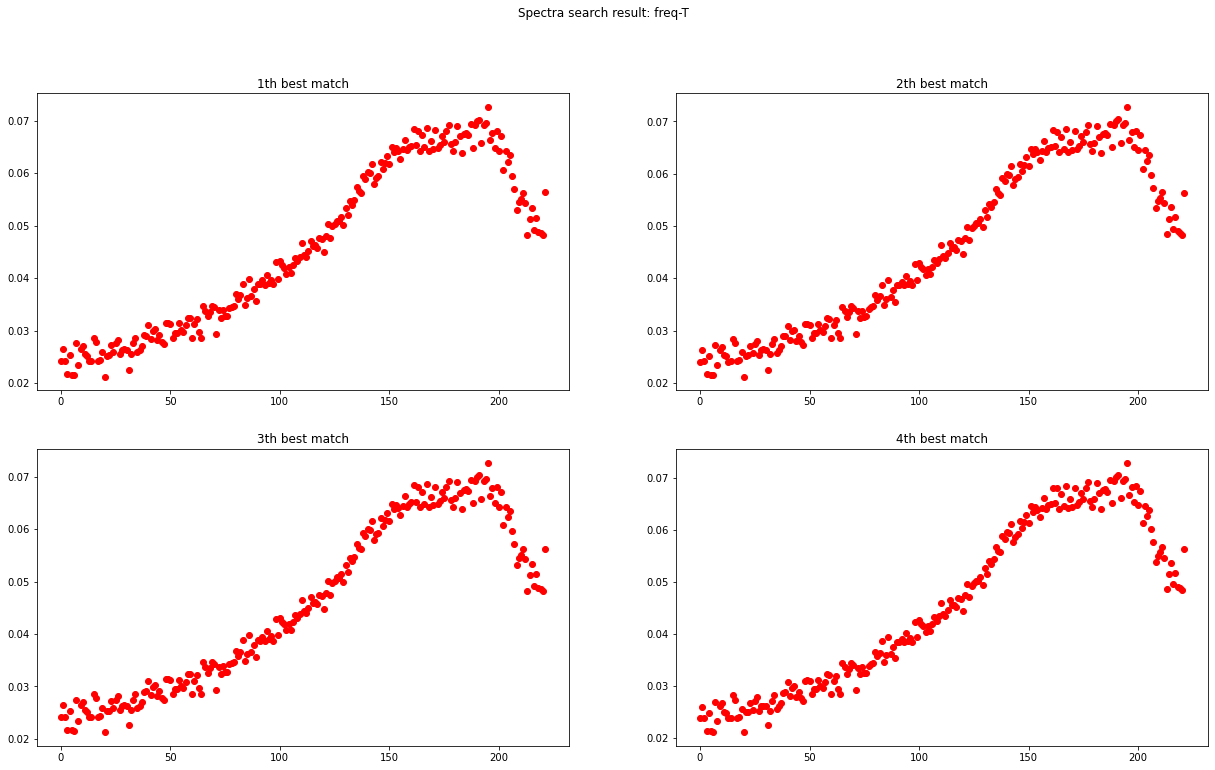

*** Reruning RCWA on picked params
Freq truncate.
freq.shape: (222,)
[ 1 / 10 ]
Calculation Progress: 100%
[ 2 / 10 ]
Calculation Progress: 100%
[ 3 / 10 ]
Calculation Progress: 100%
[ 4 / 10 ]
Calculation Progress: 100%
[ 5 / 10 ]
Calculation Progress: 100%
[ 6 / 10 ]
Calculation Progress: 100%
[ 7 / 10 ]
Calculation Progress: 100%
[ 8 / 10 ]
Calculation Progress: 100%
[ 9 / 10 ]
Calculation Progress: 100%
[ 10 / 10 ]
Calculation Progress: 100%
rerun_params.shape: (10, 4)
R_simu.shape: (10, 222)
T_simu.shape: (10, 222)
*** Average Loss between Trained Spectra and RCWA Spectra: 0.4097991540179414


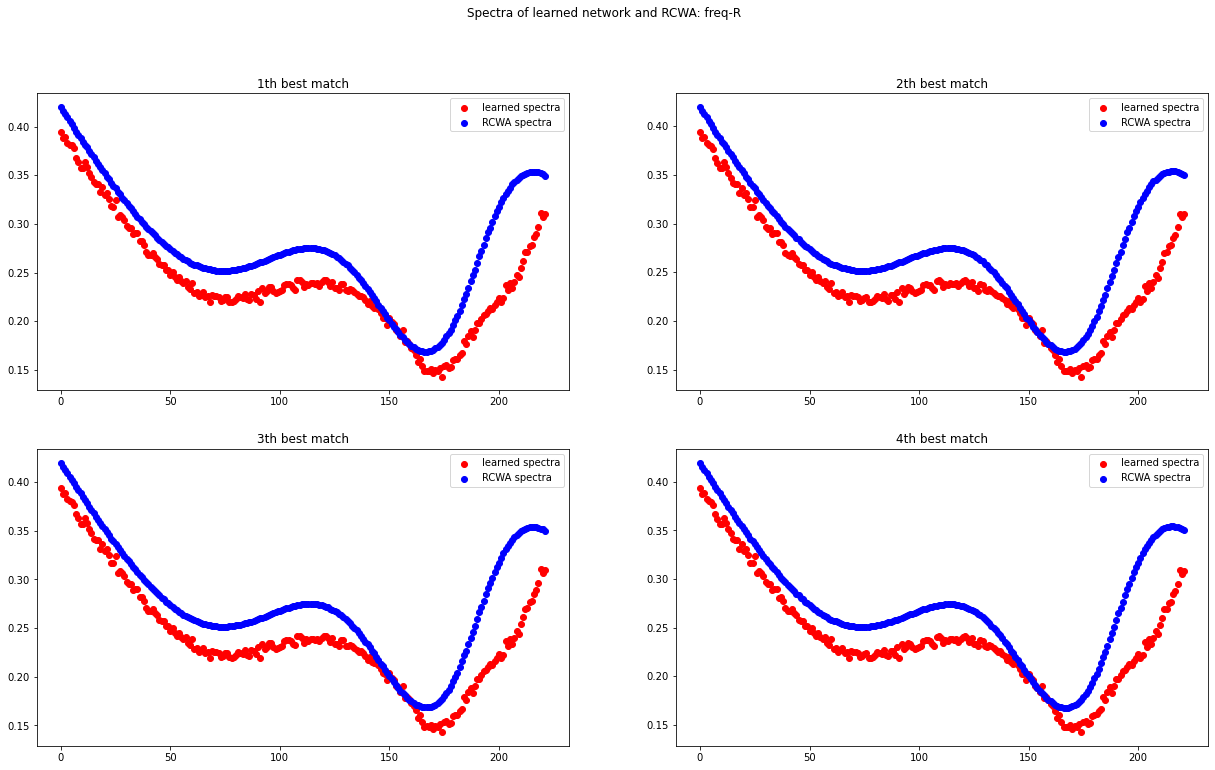

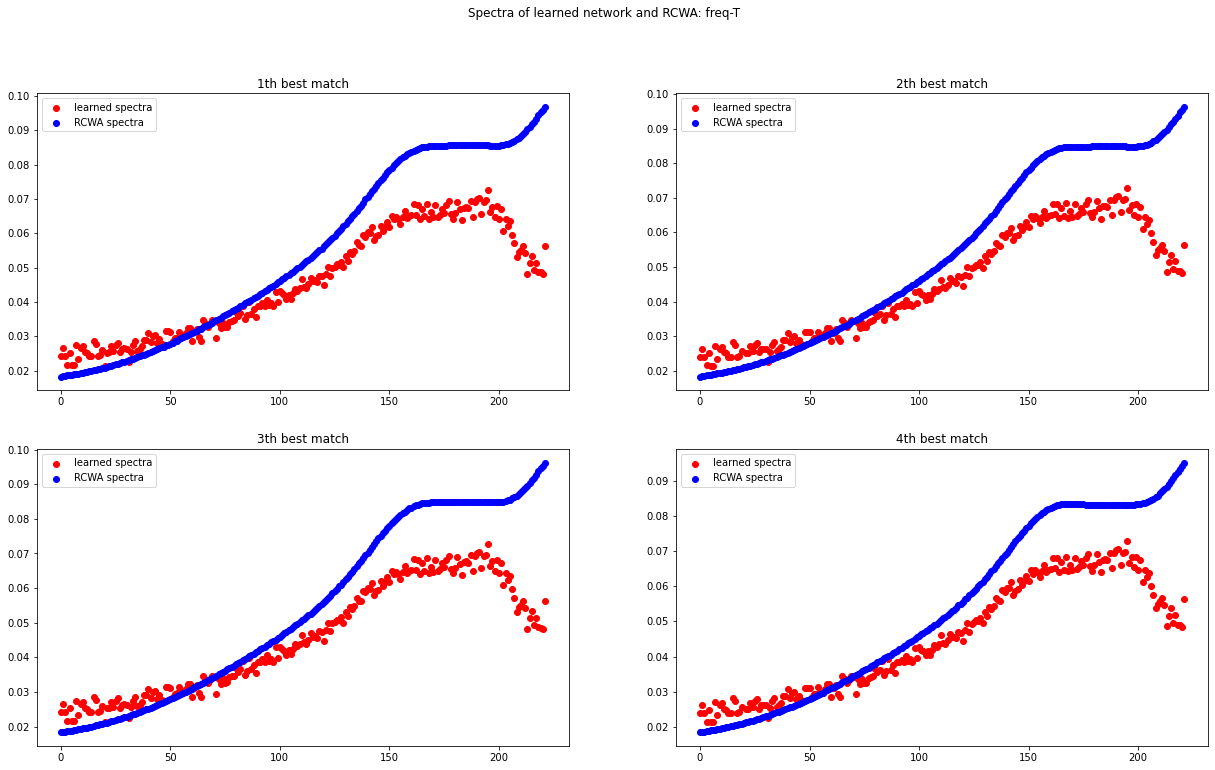

Model saved.
**************************** ROUND 3 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 45
Sample points number available, continue calculating...
----------------
[ 1 / 15 ] [D1, D2] = [102. 141.]
Calculation Progress: 100%
----------------
[ 2 / 15 ] [D1, D2] = [112. 111.]
Calculation Progress: 100%
----------------
[ 3 / 15 ] [D1, D2] = [144. 112.]
Calculation Progress: 72%

KeyboardInterrupt: 

In [5]:
loss_tolerance = 1e-3
loss = loss_tolerance+1  # start from a loss that bigger than tolerance
ROUND = 1  # round number for simulation and training


# ====== RCWA simulation prepare ======
# params range, [D1, D2]
params_range = [[50,150], [50,150]]
params_decimal = [0,0]
path_material_name = 'absorber'

# solver setting: [freq_step, freq_truncate, params_mesh, PQ_order, source, device]
'''
solver setting should not being changed while sampling and training!
'''
params_mesh = [512, 512]
order = 9  # RCWA accuracy, higher to be more accurate
PQ_order = [order, order]
ginc = [0, 0, 1]  # orig [0,0,1], incident source vector, unit vec
EP = [0, 1, 0]  # orig [0,1,0], incident source polarization, unit vec
source = [ginc, EP]
device_rcwa = 'gpu'
freq_step = 4  # freq step size, bigger to save more time, while less sampling freq points
freq_truncate = 1.7  # 'none' to no truncate
solver_setting = [freq_step, freq_truncate, params_mesh, PQ_order, source, device_rcwa]

# ====== Generate pseudo params, [D1, D2] ======
range_D1 = [50,150,1]  # [range_start, range_end, step_size]
range_D2 = [50,150,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
# print(pseudo_params_D1_D2.shape)
# print(pseudo_params_D1_D2[-1])
a = 160.
t = 75.
param_other = np.array([a, t])
param_other = np.tile(param_other, (pseudo_params_D1_D2.shape[0], 1))
pseudo_params = np.concatenate((pseudo_params_D1_D2, param_other), axis=-1)  # [D1,D2,a,t]
# print(pseudo_params.shape)
# print(pseudo_params[0])

# ====== Define target spectra ======
tg_idx_freq_R = np.array([0,1])
tg_value_R = np.array([3,4])
tg_idx_freq_T = np.array([])
tg_value_T = np.array([])
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]


plt.ion()  # interactive plt while looping
while loss>loss_tolerance:
    print('**************************** ROUND', ROUND, '****************************')
    # ====== Generate Simulation ======
    num_data = 50
    if ROUND==1:
        import_list = False
    else:
        import_list = True
    params, R, T = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True)
    print('params.shape:', params.shape)
    print('R.shape:', R.shape)
    print('T.shape:', T.shape)
    
    # save all data
    path_all_data_round = './data/' + path_material_name + '/all_data_' + path_material_name + '_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_all_data_round, params=params, R=R, T=T)
    print('** Round data saved.')
    
    # generate all data stacked for all rounds
    if ROUND==1:
        params_all = params
        R_all = R
        T_all = T
    else:
        params_all = np.concatenate((params_all, params), axis=0)
        R_all = np.concatenate((R_all, R), axis=0)
        T_all = np.concatenate((T_all, T), axis=0)
    print('params_all.shape:', params_all.shape)
    print('R_all.shape:', R_all.shape)
    print('T_all.shape:', T_all.shape)
    path_all_data = './data/' + path_material_name + '/all_data_' + path_material_name + '.npz'
    np.savez(path_all_data, params=params_all, R=R_all, T=T_all)
    print('** All Rounds data saved.')
    
    
    # ====== Train Model with Simulation Data ======
    # prepare dataset
    dataset, dataloader = data_utils.generate_dataset(path_all_data, idx_pick_param=[], BTSZ=1)
    len_train = int((len(dataset)*0.7)//1)
    len_test = len(dataset)-len_train
    dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
    print('LEN dataset_train:', len(dataset_train))
    print('LEN dataset_test:', len(dataset_test))
    BTSZ = 20
    dataloader_train = DataLoader(dataset_train, batch_size=BTSZ, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BTSZ, shuffle=True)
    print('LEN dataloader_train:', len(dataloader_train))
    print('LEN dataloader_test:', len(dataloader_test))
    
    # import network
    if ROUND==1:
        dim_in = params_all.shape[-1]  # N_param
        dim_out = R_all.shape[-1]  # N_freq
        net_dense = DenseConvTranspose1D(dim_in,dim_out)
        net_dense = net_dense.to(device)
    
    # *** train network
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
    criteon = nn.MSELoss()
    scheduler = None
    N_epoch = 2000  # number of epochs trained
    loss_train, loss_test = training_utils.train_model(dataloader, dataloader_test, optimizer, criteon, net_dense, device, NUM_EPOCH=N_epoch, scheduler=scheduler)
    print('** loss_train', loss_train)
    print('** loss_test', loss_test)
    
    # visualize spectra on test set
    visualize_trained_net(dataloader_test)
    
    
    # ====== Spectra Search ======
    pseudo_params, spectra_R, spectra_T = data_utils.generate_pseudo_data(pseudo_params, net_dense, device, PATH_pseudo_dataset='', flag_save_pseudo_data=False)
    pseudo_data = [pseudo_params, spectra_R, spectra_T]
    param_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=10)
    print('param_pick.shape:', param_pick.shape)
    print('param_pick:', param_pick)
    print('R_pick.shape:', R_pick.shape)
    print('T_pick.shape:', T_pick.shape)
    # visualize spectra search results
    visualize_spectra_search(param_pick, R_pick, T_pick)
    
    
    # ====== Run RCWA Search on Picked Params ======
    print('*** Reruning RCWA on picked params')
    rerun_params, R_simu, T_simu = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=param_pick)
    
    print('rerun_params.shape:', rerun_params.shape)
    print('R_simu.shape:', R_simu.shape)  # [N_top, N_freq]
    print('T_simu.shape:', T_simu.shape)
    # loss between learned spectra and simulated spectra
    loss_R = np.average(np.linalg.norm(R_pick-R_simu, ord=2, axis=-1))
    loss_T = np.average(np.linalg.norm(T_pick-T_simu, ord=2, axis=-1))
    loss_RT_avg = np.average([loss_R, loss_T])
    loss = loss_RT_avg
    
    print('*** Average Loss between Trained Spectra and RCWA Spectra:', loss_RT_avg)
    # visualize learned spectra and RCWA true spectra
    visualize_learned_and_rcwa(param_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12))
    
    # ====== Save Trained Model ======
    PATH_MODEL = './trained_models/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
    torch.save(net_dense.state_dict(), PATH_MODEL)
    print('** Model saved.')
    
#     if ROUND>3:
#         loss = 1e-7
    ROUND += 1
    
plt.ioff()

## Save Trained Model

In [ ]:
PATH_MODEL = './trained_models/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
torch.save(net_dense.state_dict(), PATH_MODEL)
print('Model saved.')

In [16]:
a = np.array([[3,4,6,7],
              [7,8,2,1],
              [3,5,2,1]])

b = np.array([[1,4,6,9],
              [7,8,2,5],
              [3,5,2,1]])
print(a-b)
print(np.linalg.norm(a-b, ord=2, axis=-1))
print(np.average(np.linalg.norm(a-b, ord=2, axis=-1)))

print(np.average((3,4)))

[[ 2  0  0 -2]
 [ 0  0  0 -4]
 [ 0  0  0  0]]
[2.82842712 4.         0.        ]
2.2761423749153966
3.5


In [4]:
a = [1,9,2]
b = [2,5,1]
list = [a,b]

pseudo_params = data_utils.generate_pseudo_params(list)
print(pseudo_params)


range_D1 = [50,150,1]
range_D2 = [50,150,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
print(pseudo_params_D1_D2.shape)
print(pseudo_params_D1_D2[-1])
a = 160.
t = 75.
param_other = np.array([a, t])
param_other = np.tile(param_other, (pseudo_params_D1_D2.shape[0], 1))
pseudo_params = np.concatenate((pseudo_params_D1_D2, param_other), axis=-1)
print(pseudo_params.shape)
print(pseudo_params[0])

[[1 2]
 [1 3]
 [1 4]
 [3 2]
 [3 3]
 [3 4]
 [5 2]
 [5 3]
 [5 4]
 [7 2]
 [7 3]
 [7 4]]
(10000, 2)
[149 149]
(10000, 4)
[ 50.  50. 160.  75.]


In [8]:
params_pseudo = np.array([[0.1,0.2,0.5],
                          [0.6,0.7,0.9],
                          [0.8,0.8,0.8]])

spectraR_pseudo = np.array([[3,4,6,7],
                            [7,8,2,1],
                            [3,5,2,1]])

spectraT_pseudo = np.array([[9,4,6,9],
                            [9,8,2,9],
                            [9,3,2,9]])

tg_idx_freq_R = np.array([0,1])
tg_value_R = np.array([3,4])
tg_idx_freq_T = np.array([])
tg_value_T = np.array([])

pseudo_data = [params_pseudo, spectraR_pseudo, spectraT_pseudo]
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]
# if tg_idx_freq_R.size !=0 and tg_idx_freq_T.size==0:
#     print('search R')



param_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=5)
print(param_pick)

[[0.1 0.2 0.5]
 [0.8 0.8 0.8]
 [0.6 0.7 0.9]]
